# Mise en place du notebook

## Import des modules

In [1]:
%autosave 3600

Autosaving every 3600 seconds


In [24]:
# imports pour la production
import warnings
from IPython.core.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from tqdm.notebook import tqdm_notebook
from pympler.asizeof import asizeof
import boto3


## Gestion des paramètres d'affichage de Jupyter

In [3]:
plt.style.use('seaborn')

warnings.filterwarnings(category=FutureWarning, action='ignore')

# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.set_option("colheader_justify", "left")

# pour gérer l'affichage des arrays numpy
# 230 sur config bureau, 165 sur config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
HTML("<style>.container { width:100% }</style>")

## Liens utiles

Enoncé OC : https://openclassrooms.com/fr/paths/164/projects/633/assignment  
Liens vers les données Kaggle : https://www.kaggle.com/moltean/fruits  
        

## Configurations d'accès à AWS : clés SSH, tokens, credentials, etc...

### Tokens AWS CLI

A renseigner une seule fois, lors la première connexion avec AWS CLI

### Connexions SSH au cluster manager EMR

Clé privée dans un fichier .pem dans ~/.ssh sur PC local.  
  
Fichier ~/.ssh/config sur PC local :  
Host *.eu-west-1.compute.amazonaws.com  
IdentityFile ~/.ssh/cle_irelande.pem


## Gestion des chemins

In [4]:
dirpath = os.getcwd()
print("Working directory is :", dirpath)

Working directory is : /home/jim/projet8


In [5]:
# Liste les fichiers du working directory
print("Liste les fichiers du working directory :", os.listdir(dirpath))

Liste les fichiers du working directory : ['Projet 8 v08.ipynb', 'cat.jpg', 'Projet 8 v04.ipynb', 'Projet 8 v01.ipynb', 'Projet 8 v07.ipynb', 'Projet 8 v06.ipynb', 'input', 'Projet 8 v05.ipynb', 'filename', 'Tests Jupyter v1.ipynb', '.ipynb_checkpoints', 'Projet 8 v03.ipynb', 'Projet 8 v02.ipynb', 'df_output_30_fruits.csv']


In [6]:
# Répertoires de photos de fruits en local
list_input_dir = sorted(os.listdir(os.path.join(dirpath, 'input')))
print("Répertoires de photos de fruits en local :", list_input_dir)

Répertoires de photos de fruits en local : ['Apple Braeburn', 'Apricot', 'Avocado', 'Banana', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Carambula', 'Cauliflower']


## Dataframe output de la feature extraction

### Initialisation

In [7]:
# dataframe pandas avec 4096+1 colonnes
def initialize_df_output():
    return pd.DataFrame(columns = [f'dim_{i}' for i in range(4096)]+['path'])

df_output = initialize_df_output()
df_output

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,dim_37,dim_38,dim_39,dim_40,dim_41,dim_42,dim_43,dim_44,dim_45,dim_46,dim_47,dim_48,dim_49,dim_50,dim_51,dim_52,dim_53,dim_54,dim_55,dim_56,dim_57,dim_58,dim_59,dim_60,dim_61,dim_62,dim_63,dim_64,dim_65,dim_66,dim_67,dim_68,dim_69,dim_70,dim_71,dim_72,dim_73,dim_74,dim_75,dim_76,dim_77,dim_78,dim_79,dim_80,dim_81,dim_82,dim_83,dim_84,dim_85,dim_86,dim_87,dim_88,dim_89,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,dim_96,dim_97,dim_98,dim_99,...,dim_3997,dim_3998,dim_3999,dim_4000,dim_4001,dim_4002,dim_4003,dim_4004,dim_4005,dim_4006,dim_4007,dim_4008,dim_4009,dim_4010,dim_4011,dim_4012,dim_4013,dim_4014,dim_4015,dim_4016,dim_4017,dim_4018,dim_4019,dim_4020,dim_4021,dim_4022,dim_4023,dim_4024,dim_4025,dim_4026,dim_4027,dim_4028,dim_4029,dim_4030,dim_4031,dim_4032,dim_4033,dim_4034,dim_4035,dim_4036,dim_4037,dim_4038,dim_4039,dim_4040,dim_4041,dim_4042,dim_4043,dim_4044,dim_4045,dim_4046,dim_4047,dim_4048,dim_4049,dim_4050,dim_4051,dim_4052,dim_4053,dim_4054,dim_4055,dim_4056,dim_4057,dim_4058,dim_4059,dim_4060,dim_4061,dim_4062,dim_4063,dim_4064,dim_4065,dim_4066,dim_4067,dim_4068,dim_4069,dim_4070,dim_4071,dim_4072,dim_4073,dim_4074,dim_4075,dim_4076,dim_4077,dim_4078,dim_4079,dim_4080,dim_4081,dim_4082,dim_4083,dim_4084,dim_4085,dim_4086,dim_4087,dim_4088,dim_4089,dim_4090,dim_4091,dim_4092,dim_4093,dim_4094,dim_4095,path


### Fonction de concaténation des features extraites

In [8]:
def append_to_dataframe(concatenated_dataframe, np_array, path):
    """Appends a vector to the output dataframe.
    Args : 
    - concatenated_dataframe : dataframe of dimension 4097.
    - np_array : numpy array (output of VGG16 feature extraction).
    - path : string of the path to the image.
    Returns :
    - dataframe to which (np_vector, path) has been appended.
    """
    df_single_line = pd.DataFrame(np_array, columns=[f'dim_{i}' for i in range(4096)])
    df_single_line['path'] = path
    return pd.concat([concatenated_dataframe, df_single_line])

In [26]:
# Test unitaire
test_np_array = np.linspace(0,1,4096).reshape(1,4096)   # same shape as VGG16 output

for i in range(1000):
    df_output = append_to_dataframe(df_output, test_np_array, 'blabla')

In [27]:
asizeof(df_output) / 2**30

0.09959038347005844

250ms pour 100 concaténations.  
5.1s pour 1000 concaténations.  Le df_output pèse 97 Mo.
4min50s pour 10000 concaténations. 61s pour 1000 concaténations additionnelles en partant d'un df_output à 10000 lignes.  Le df_output pèse 1.0 Go pour 11000 lignes.
  
Parfait, c'est rapide.  
Mais au-delà de 10000 concaténations, le df_output commence à devenir un peu trop gros.  

## VGG-16

### Fonction de feature extraction

On déroule cette méthodologie :  
    https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/  
Chapitre : Pre-Trained Model as Feature Extractor Preprocessor  

In [11]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

2022-01-12 16:21:38.303093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 16:21:38.303425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-12 16:21:38.303495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-12 16:21:38.303548: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-12 16:21:38.303600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [32]:
print("Poids = ", asizeof(model) / 2**10, "ko")

Poids =  532.9609375 ko


In [12]:
def VGG16_extracteur(nom_image):
    """Transforme un fichier image en un vecteur de dimension 4096.
    Args : 
    - nom_image : chemin d'accès à l'image.
    Returns :
    - array numpy (vecteur de dimension 4096).
    """
    # load an image from file
    image = load_img(nom_image, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get extracted features
    im_features = model.predict(image)
    return im_features


# test unitaire
arr_cat = VGG16_extracteur('cat.jpg')
arr_cat

array([[0.      , 0.      , 4.132894, ..., 0.      , 0.      , 1.660564]], dtype=float32)

# Réductions de dimension en local sans Spark

## Stockage des data en local

On sélectionne 10 répertoires de données (1 pour les 10 premiers fruits de l'alphabet) depuis le répertoire local :  
~/Downloads/archive/fruits-360_dataset/fruits-360/Training  
que l'on exporte vers le répertoire WORKING-DIRECTORY/input/

### Inventaire des images chargées en local

In [13]:
# Répertoires de photos de fruits en local
for i in range(len(list_input_dir)):
    list_images = sorted(os.listdir(os.path.join(dirpath, 'input', list_input_dir[i])))
    print(f"Nb images de '{list_input_dir[i]}' :", len(list_images))

Nb images de 'Apple Braeburn' : 492
Nb images de 'Apricot' : 492
Nb images de 'Avocado' : 427
Nb images de 'Banana' : 490
Nb images de 'Beetroot' : 450
Nb images de 'Blueberry' : 462
Nb images de 'Cactus fruit' : 490
Nb images de 'Cantaloupe 1' : 492
Nb images de 'Carambula' : 490
Nb images de 'Cauliflower' : 702


### Batch de 100 images (10 images de 10 fruits différents)

In [14]:
N_IMAGES = 3   # nb d'images par fruits

batch_img = []
random.seed(42)
for i in range(len(list_input_dir)):   # l'itérateur parcourt les différents fruits
    list_images = sorted(os.listdir(os.path.join(dirpath, 'input', list_input_dir[i])))
    samples = random.sample(list_images, N_IMAGES)    # fait un tirage sans remise.
    for j in range(N_IMAGES):   # l'itérateur parcourt les N images samplées
        batch_img.append(list_input_dir[i] + '/' + samples[j])
batch_img = sorted(batch_img)
display(batch_img)

['Apple Braeburn/110_100.jpg',
 'Apple Braeburn/151_100.jpg',
 'Apple Braeburn/r_173_100.jpg',
 'Apricot/212_100.jpg',
 'Apricot/226_100.jpg',
 'Apricot/r_21_100.jpg',
 'Avocado/164_100.jpg',
 'Avocado/202_100.jpg',
 'Avocado/r_277_100.jpg',
 'Banana/175_100.jpg',
 'Banana/r_196_100.jpg',
 'Banana/r_251_100.jpg',
 'Beetroot/174_100.jpg',
 'Beetroot/r2_4_100.jpg',
 'Beetroot/r_101_100.jpg',
 'Blueberry/113_100.jpg',
 'Blueberry/114_100.jpg',
 'Blueberry/87_100.jpg',
 'Cactus fruit/142_100.jpg',
 'Cactus fruit/227_100.jpg',
 'Cactus fruit/235_100.jpg',
 'Cantaloupe 1/164_100.jpg',
 'Cantaloupe 1/r_146_100.jpg',
 'Cantaloupe 1/r_191_100.jpg',
 'Carambula/249_100.jpg',
 'Carambula/r_138_100.jpg',
 'Carambula/r_282_100.jpg',
 'Cauliflower/r2_65_100.jpg',
 'Cauliflower/r_213_100.jpg',
 'Cauliflower/r_67_100.jpg']

### Calcul des features extraites

In [15]:
df_output = initialize_df_output()

for img in tqdm_notebook(batch_img):
    img_path = os.path.join(dirpath, 'input', img)
    df_output = append_to_dataframe(df_output, VGG16_extracteur(img_path), img)
    
display(df_output)

  0%|          | 0/30 [00:00<?, ?it/s]

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,dim_37,dim_38,dim_39,dim_40,dim_41,dim_42,dim_43,dim_44,dim_45,dim_46,dim_47,dim_48,dim_49,dim_50,dim_51,dim_52,dim_53,dim_54,dim_55,dim_56,dim_57,dim_58,dim_59,dim_60,dim_61,dim_62,dim_63,dim_64,dim_65,dim_66,dim_67,dim_68,dim_69,dim_70,dim_71,dim_72,dim_73,dim_74,dim_75,dim_76,dim_77,dim_78,dim_79,dim_80,dim_81,dim_82,dim_83,dim_84,dim_85,dim_86,dim_87,dim_88,dim_89,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,dim_96,dim_97,dim_98,dim_99,...,dim_3997,dim_3998,dim_3999,dim_4000,dim_4001,dim_4002,dim_4003,dim_4004,dim_4005,dim_4006,dim_4007,dim_4008,dim_4009,dim_4010,dim_4011,dim_4012,dim_4013,dim_4014,dim_4015,dim_4016,dim_4017,dim_4018,dim_4019,dim_4020,dim_4021,dim_4022,dim_4023,dim_4024,dim_4025,dim_4026,dim_4027,dim_4028,dim_4029,dim_4030,dim_4031,dim_4032,dim_4033,dim_4034,dim_4035,dim_4036,dim_4037,dim_4038,dim_4039,dim_4040,dim_4041,dim_4042,dim_4043,dim_4044,dim_4045,dim_4046,dim_4047,dim_4048,dim_4049,dim_4050,dim_4051,dim_4052,dim_4053,dim_4054,dim_4055,dim_4056,dim_4057,dim_4058,dim_4059,dim_4060,dim_4061,dim_4062,dim_4063,dim_4064,dim_4065,dim_4066,dim_4067,dim_4068,dim_4069,dim_4070,dim_4071,dim_4072,dim_4073,dim_4074,dim_4075,dim_4076,dim_4077,dim_4078,dim_4079,dim_4080,dim_4081,dim_4082,dim_4083,dim_4084,dim_4085,dim_4086,dim_4087,dim_4088,dim_4089,dim_4090,dim_4091,dim_4092,dim_4093,dim_4094,dim_4095,path
0,0.0,0.000000,0.000000,2.363457,0.000000,0.000000,5.753050,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.822324,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.876393,0.000000,0.000000,2.378261,2.099965,2.944819,1.808272,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.592693,6.860825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.685811,0.000000,5.926198,0.0,0.132211,0.763508,0.000000,0.787312,0.000000,0.0,0.998741,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.538932,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.292179,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,1.885774,0.000000,0.201606,2.174223,0.000000,0.703131,0.000000,0.000000,0.000000,0.000000,0.000000,0.076951,0.000000,0.000000,0.000000,4.658242,1.877420,0.000000,0.000000,0.000000,0.000000,0.272653,0.351495,0.000000,4.478815,0.000000,3.266395,0.0,0.000000,0.000000,0.182044,1.066797,0.000000,3.427037,1.314594,0.000000,0.000000,2.192712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.678623,0.000000,0.000000,4.613783,2.378513,1.860390,0.000000,0.000000,2.060694,2.910172,0.0,0.0,0.000000,0.0,0.762518,0.0,3.374437,0.000000,0.000000,0.000000,0.000000,0.0,0.832530,0.000000,0.000000,0.000000,3.016428,0.000000,2.997432,1.171421,0.000000,0.0,0.000000,0.527215,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.106610,0.000000,0.783764,0.0,0.000000,1.028740,0.000000,6.486232,0.000000,0.195561,0.000000,Apple Braeburn/110_100.jpg
0,0.0,0.000000,0.000000,1.675637,0.000000,0.000000,6.319502,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.371343,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.557548,0.000000,0.000000,2.230097,2.812769,0.394682,1.712926,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.724589,6.778735,0.000000,0.861946,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.861238,0.000000,4.215691,0.0,0.653812,1.011819,0.000000,0.837972,0.000000,0.0,1.632736,0.000000,0.286992,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.644090,0.0,0.000000,0.0,0

In [16]:
df_output.to_csv(path_or_buf=os.path.join(dirpath, f'df_output_{len(df_output)}_fruits.csv'))

## Stockage des data sur S3

On sélectionne 10 répertoires de données (1 pour les 10 premiers fruits de l'alphabet) depuis le répertoire local :  
~/Downloads/archive/fruits-360_dataset/fruits-360/Training  
que l'on exporte vers le "répertoire" :  
s3://input/

### Inventaire des images chargées sur S3

In [17]:
# connexion au bucket
s3_bucket = boto3.resource('s3').Bucket('oc-projet-8')

In [18]:
all_files = s3_bucket.objects.all()
print("Nb de fichiers dans le bucket :", sum(1 for _ in all_files))
print("\nFichiers dans le bucket :")
for obj in all_files:
    print(obj.key)

Nb de fichiers dans le bucket : 4993

Fichiers dans le bucket :
input/Apple Braeburn/0_100.jpg
input/Apple Braeburn/100_100.jpg
input/Apple Braeburn/101_100.jpg
input/Apple Braeburn/102_100.jpg
input/Apple Braeburn/103_100.jpg
input/Apple Braeburn/104_100.jpg
input/Apple Braeburn/105_100.jpg
input/Apple Braeburn/106_100.jpg
input/Apple Braeburn/107_100.jpg
input/Apple Braeburn/108_100.jpg
input/Apple Braeburn/109_100.jpg
input/Apple Braeburn/10_100.jpg
input/Apple Braeburn/110_100.jpg
input/Apple Braeburn/111_100.jpg
input/Apple Braeburn/112_100.jpg
input/Apple Braeburn/113_100.jpg
input/Apple Braeburn/114_100.jpg
input/Apple Braeburn/115_100.jpg
input/Apple Braeburn/116_100.jpg
input/Apple Braeburn/117_100.jpg
input/Apple Braeburn/118_100.jpg
input/Apple Braeburn/119_100.jpg
input/Apple Braeburn/11_100.jpg
input/Apple Braeburn/120_100.jpg
input/Apple Braeburn/121_100.jpg
input/Apple Braeburn/122_100.jpg
input/Apple Braeburn/123_100.jpg
input/Apple Braeburn/124_100.jpg
input/Apple Brae

input/Avocado/114_100.jpg
input/Avocado/115_100.jpg
input/Avocado/116_100.jpg
input/Avocado/117_100.jpg
input/Avocado/118_100.jpg
input/Avocado/119_100.jpg
input/Avocado/11_100.jpg
input/Avocado/120_100.jpg
input/Avocado/121_100.jpg
input/Avocado/122_100.jpg
input/Avocado/123_100.jpg
input/Avocado/124_100.jpg
input/Avocado/125_100.jpg
input/Avocado/126_100.jpg
input/Avocado/127_100.jpg
input/Avocado/128_100.jpg
input/Avocado/129_100.jpg
input/Avocado/12_100.jpg
input/Avocado/130_100.jpg
input/Avocado/131_100.jpg
input/Avocado/132_100.jpg
input/Avocado/133_100.jpg
input/Avocado/134_100.jpg
input/Avocado/135_100.jpg
input/Avocado/136_100.jpg
input/Avocado/137_100.jpg
input/Avocado/138_100.jpg
input/Avocado/139_100.jpg
input/Avocado/13_100.jpg
input/Avocado/140_100.jpg
input/Avocado/141_100.jpg
input/Avocado/142_100.jpg
input/Avocado/143_100.jpg
input/Avocado/144_100.jpg
input/Avocado/145_100.jpg
input/Avocado/146_100.jpg
input/Avocado/147_100.jpg
input/Avocado/148_100.jpg
input/Avocado/1

input/Beetroot/53_100.jpg
input/Beetroot/54_100.jpg
input/Beetroot/55_100.jpg
input/Beetroot/56_100.jpg
input/Beetroot/57_100.jpg
input/Beetroot/58_100.jpg
input/Beetroot/59_100.jpg
input/Beetroot/5_100.jpg
input/Beetroot/61_100.jpg
input/Beetroot/62_100.jpg
input/Beetroot/63_100.jpg
input/Beetroot/64_100.jpg
input/Beetroot/65_100.jpg
input/Beetroot/66_100.jpg
input/Beetroot/67_100.jpg
input/Beetroot/68_100.jpg
input/Beetroot/69_100.jpg
input/Beetroot/6_100.jpg
input/Beetroot/70_100.jpg
input/Beetroot/71_100.jpg
input/Beetroot/72_100.jpg
input/Beetroot/73_100.jpg
input/Beetroot/74_100.jpg
input/Beetroot/75_100.jpg
input/Beetroot/76_100.jpg
input/Beetroot/77_100.jpg
input/Beetroot/78_100.jpg
input/Beetroot/79_100.jpg
input/Beetroot/7_100.jpg
input/Beetroot/80_100.jpg
input/Beetroot/81_100.jpg
input/Beetroot/82_100.jpg
input/Beetroot/83_100.jpg
input/Beetroot/84_100.jpg
input/Beetroot/85_100.jpg
input/Beetroot/86_100.jpg
input/Beetroot/87_100.jpg
input/Beetroot/88_100.jpg
input/Beetroot/

input/Cactus fruit/3_100.jpg
input/Cactus fruit/40_100.jpg
input/Cactus fruit/41_100.jpg
input/Cactus fruit/42_100.jpg
input/Cactus fruit/43_100.jpg
input/Cactus fruit/45_100.jpg
input/Cactus fruit/4_100.jpg
input/Cactus fruit/54_100.jpg
input/Cactus fruit/55_100.jpg
input/Cactus fruit/56_100.jpg
input/Cactus fruit/57_100.jpg
input/Cactus fruit/58_100.jpg
input/Cactus fruit/59_100.jpg
input/Cactus fruit/5_100.jpg
input/Cactus fruit/60_100.jpg
input/Cactus fruit/61_100.jpg
input/Cactus fruit/62_100.jpg
input/Cactus fruit/63_100.jpg
input/Cactus fruit/64_100.jpg
input/Cactus fruit/65_100.jpg
input/Cactus fruit/66_100.jpg
input/Cactus fruit/67_100.jpg
input/Cactus fruit/68_100.jpg
input/Cactus fruit/69_100.jpg
input/Cactus fruit/6_100.jpg
input/Cactus fruit/70_100.jpg
input/Cactus fruit/71_100.jpg
input/Cactus fruit/72_100.jpg
input/Cactus fruit/73_100.jpg
input/Cactus fruit/74_100.jpg
input/Cactus fruit/75_100.jpg
input/Cactus fruit/76_100.jpg
input/Cactus fruit/77_100.jpg
input/Cactus f

input/Carambula/49_100.jpg
input/Carambula/4_100.jpg
input/Carambula/50_100.jpg
input/Carambula/51_100.jpg
input/Carambula/52_100.jpg
input/Carambula/53_100.jpg
input/Carambula/54_100.jpg
input/Carambula/55_100.jpg
input/Carambula/56_100.jpg
input/Carambula/57_100.jpg
input/Carambula/58_100.jpg
input/Carambula/59_100.jpg
input/Carambula/5_100.jpg
input/Carambula/60_100.jpg
input/Carambula/61_100.jpg
input/Carambula/62_100.jpg
input/Carambula/63_100.jpg
input/Carambula/64_100.jpg
input/Carambula/65_100.jpg
input/Carambula/66_100.jpg
input/Carambula/67_100.jpg
input/Carambula/68_100.jpg
input/Carambula/69_100.jpg
input/Carambula/6_100.jpg
input/Carambula/70_100.jpg
input/Carambula/71_100.jpg
input/Carambula/72_100.jpg
input/Carambula/73_100.jpg
input/Carambula/74_100.jpg
input/Carambula/75_100.jpg
input/Carambula/76_100.jpg
input/Carambula/77_100.jpg
input/Carambula/78_100.jpg
input/Carambula/79_100.jpg
input/Carambula/7_100.jpg
input/Carambula/80_100.jpg
input/Carambula/81_100.jpg
input

###### Test de l'accès à une image

In [19]:
s3_bucket.download_file('input/Cauliflower/r_198_100.jpg', '/tmp/img')

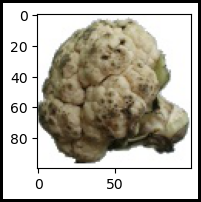

In [20]:
from matplotlib.image import imread
image = imread('/tmp/img')
plt.style.use('default')
plt.figure(figsize=(2, 2), edgecolor='black', linewidth=4)
plt.imshow(image)
plt.show()

### Calcul des features extraites

In [21]:
df_output = initialize_df_output()

img_path = '/tmp/img'
for img in tqdm_notebook(batch_img):
    s3_bucket.download_file('input/' + img, img_path)
    df_output = append_to_dataframe(df_output, VGG16_extracteur(img_path), img)

display(df_output)

  0%|          | 0/30 [00:00<?, ?it/s]

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,dim_37,dim_38,dim_39,dim_40,dim_41,dim_42,dim_43,dim_44,dim_45,dim_46,dim_47,dim_48,dim_49,dim_50,dim_51,dim_52,dim_53,dim_54,dim_55,dim_56,dim_57,dim_58,dim_59,dim_60,dim_61,dim_62,dim_63,dim_64,dim_65,dim_66,dim_67,dim_68,dim_69,dim_70,dim_71,dim_72,dim_73,dim_74,dim_75,dim_76,dim_77,dim_78,dim_79,dim_80,dim_81,dim_82,dim_83,dim_84,dim_85,dim_86,dim_87,dim_88,dim_89,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,dim_96,dim_97,dim_98,dim_99,...,dim_3997,dim_3998,dim_3999,dim_4000,dim_4001,dim_4002,dim_4003,dim_4004,dim_4005,dim_4006,dim_4007,dim_4008,dim_4009,dim_4010,dim_4011,dim_4012,dim_4013,dim_4014,dim_4015,dim_4016,dim_4017,dim_4018,dim_4019,dim_4020,dim_4021,dim_4022,dim_4023,dim_4024,dim_4025,dim_4026,dim_4027,dim_4028,dim_4029,dim_4030,dim_4031,dim_4032,dim_4033,dim_4034,dim_4035,dim_4036,dim_4037,dim_4038,dim_4039,dim_4040,dim_4041,dim_4042,dim_4043,dim_4044,dim_4045,dim_4046,dim_4047,dim_4048,dim_4049,dim_4050,dim_4051,dim_4052,dim_4053,dim_4054,dim_4055,dim_4056,dim_4057,dim_4058,dim_4059,dim_4060,dim_4061,dim_4062,dim_4063,dim_4064,dim_4065,dim_4066,dim_4067,dim_4068,dim_4069,dim_4070,dim_4071,dim_4072,dim_4073,dim_4074,dim_4075,dim_4076,dim_4077,dim_4078,dim_4079,dim_4080,dim_4081,dim_4082,dim_4083,dim_4084,dim_4085,dim_4086,dim_4087,dim_4088,dim_4089,dim_4090,dim_4091,dim_4092,dim_4093,dim_4094,dim_4095,path
0,0.0,0.000000,0.000000,2.363457,0.000000,0.000000,5.753050,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.822324,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.876393,0.000000,0.000000,2.378261,2.099965,2.944819,1.808272,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.592693,6.860825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.685811,0.000000,5.926198,0.0,0.132211,0.763508,0.000000,0.787312,0.000000,0.0,0.998741,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.538932,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.292179,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,1.885774,0.000000,0.201606,2.174223,0.000000,0.703131,0.000000,0.000000,0.000000,0.000000,0.000000,0.076951,0.000000,0.000000,0.000000,4.658242,1.877420,0.000000,0.000000,0.000000,0.000000,0.272653,0.351495,0.000000,4.478815,0.000000,3.266395,0.0,0.000000,0.000000,0.182044,1.066797,0.000000,3.427037,1.314594,0.000000,0.000000,2.192712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.678623,0.000000,0.000000,4.613783,2.378513,1.860390,0.000000,0.000000,2.060694,2.910172,0.0,0.0,0.000000,0.0,0.762518,0.0,3.374437,0.000000,0.000000,0.000000,0.000000,0.0,0.832530,0.000000,0.000000,0.000000,3.016428,0.000000,2.997432,1.171421,0.000000,0.0,0.000000,0.527215,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.106610,0.000000,0.783764,0.0,0.000000,1.028740,0.000000,6.486232,0.000000,0.195561,0.000000,Apple Braeburn/110_100.jpg
0,0.0,0.000000,0.000000,1.675637,0.000000,0.000000,6.319502,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.371343,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.557548,0.000000,0.000000,2.230097,2.812769,0.394682,1.712926,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.724589,6.778735,0.000000,0.861946,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.861238,0.000000,4.215691,0.0,0.653812,1.011819,0.000000,0.837972,0.000000,0.0,1.632736,0.000000,0.286992,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.644090,0.0,0.000000,0.0,0

In [22]:
# upload output to s3 via un fichier local
file_name = f'df_output_{len(df_output)}_fruits.csv'
local_path = os.path.join(dirpath, file_name)
df_output.to_csv(path_or_buf=local_path)
s3_bucket.upload_file(local_path, 'output/' + file_name)

# Réductions de dimension en local avec Spark

# Réductions de dimension dans le cloud avec Spark et AWS EMR